In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, betabinom
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#preparing gp data
all_sits_goal_data = pd.read_csv('csv_files/all_sits_player_goal_data.csv')
gp_df = all_sits_goal_data[['player', 'api_id', 'season_age', 'position', 
                            'position_type', 'team', 'season', 'session', 
                            'gp', 'toi']]

gp_df = gp_df.groupby(['player', 'api_id', 'season_age', 'position', 
                       'position_type', 'season', 'session', 'team'])[['gp', 'toi']].sum().reset_index()

#get max possible games a player can play in a given season. It varies based on lockouts and
#the covid seasons
covid_season = gp_df[gp_df.season == 20192020].groupby(['team', 'season'])['gp'].max().reset_index()
gp_df = gp_df.merge(covid_season, how='left', on=['team', 'season'], suffixes=(None, '_y'))
gp_df = gp_df.rename(columns = {'gp_y': 'possible_gp'})
gp_df['possible_gp'] = np.where(gp_df['possible_gp'].isna(), 
                                np.where(gp_df['season'] == 20122013, 48, 82), 
                                gp_df['possible_gp'])

# Games Played Distributions

We're going to use the Binomial Distribution to model how many games a player plays in a season. The binomial takes 
two parameters $ n $ and $ p $. $ n $ is the number of trials we are looking for, in this case will be 82 since that's the number of games in the NHL regular season. While $ p $ is the probability of a player playing in each game. 

I picked the Beta Distribution as the prior for the distribution of $ p $ for the main reason that it is the conjugate prior of the Binomial Distribution. This makes the math much simpler and allows us to easily update our prior into a posterior distribution by simply adding the number of trials and sucesses to the parameters of our Beta prior.

Here is the formula for the Beta posterior:

$ \alpha + x $

$ \beta + N - x$

$ x $ is the number of successes and $ N $ is the number of trials. For the initial prior parameters we'll choose an $ \alpha $ and $ \beta $ that produces an expected value of the probability of playing 66 games a season which I think is reasonable for an average roster player on an NHL team. This means I will set $ \alpha = 66 $ and $ \beta = 16 $




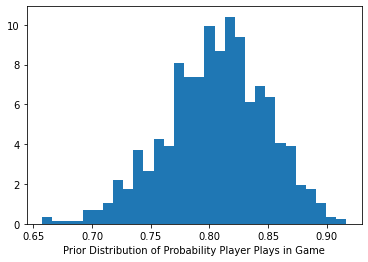

In [8]:
# Showing the distribution of our initial prior beta distribution
r = beta.rvs(66, 16, size=1000)
plt.hist(r, density=True, histtype='stepfilled', bins=30)
plt.xlabel("Prior Distribution of Probability Player Plays in Game")
plt.show()

# Modeling Process

For this im going to use the prior to predict a players first season of GP in the data. From there I will then add the evidence of that first season to the prior to get posterior parameters for the distribution of the probability a player plays in any one game. I will then take those parameters and use them in the posterior predictive distribution (in this case the Beta Binomial distribution) to predict a point estimate and a sample. From the point distribution I will compare the prediction and the true value with metrics such as $ {R}^{2} $ and Root Mean Squared Error. I will also look at the distributions and create 95% Credible Intervals and see if the true values fall within the predicted Credible Intervals 95% of the time. **Note to self look up better ways to test bayesian predictions**

Im also not going to use the entire dataset of evidence for each player. I feel that seasons from before two seasons past are really impactful in predicting whether a player so i won't include them in the calculations of updated posteriors which will only include the current season and the past two to predcit the next.

In [103]:
# get data to do predictions
players = list(gp_df.api_id.unique())
seasons = list(gp_df.season.sort_values().unique())
# list where I'll store predictions and posterior parameter values 
predictions = []



In [139]:
groups = []
grouped_df = gp_df.groupby(['api_id'])
prior_alpha = 66
prior_beta = 16
for name, group in grouped_df:
    group['gp_cum_sum_3'] = group['gp'].rolling(2, min_periods=1).sum()
    group['possible_gp_cum_sum_3'] = group['possible_gp'].rolling(2, min_periods=1).sum()
    #group['gp_cum_sum_3'] = group['gp'].cumsum()
    #group['possible_gp_cum_sum_3'] = group['possible_gp'].cumsum()
    group['posterior_alpha'] = group['gp_cum_sum_3'] + prior_alpha
    group['posterior_beta'] = group['possible_gp_cum_sum_3'] - group['gp_cum_sum_3'] + prior_beta
    group['posterior_alpha'] = group.posterior_alpha.shift(1)
    group['posterior_beta'] = group.posterior_beta.shift(1)
    #group['posterior_alpha'] = group.posterior_alpha.fillna(66)
    #group['posterior_beta'] = group.posterior_beta.fillna(16)
    point_predictions = []
    prediction_samples = []
    for row_index, row in group.iterrows():
        if pd.isna(row['posterior_alpha']):
            point_predictions.append(np.nan)
            prediction_samples.append(np.nan)
            continue
        point_predictions.append(betabinom.rvs(int(row['possible_gp']), row['posterior_alpha'], 
                                               row['posterior_beta'], size=1000).mean())
        prediction_samples.append(betabinom.rvs(int(row['possible_gp']), row['posterior_alpha'], 
                                               row['posterior_beta'], size=1000))
    
    group['point_prediction'] = point_predictions
    group['prediction_samples'] = prediction_samples
    groups.append(group)
new_grouped_df = pd.concat(groups)
df = new_grouped_df.dropna()
#df[df.api_id == 8471675].head(20)

# Evaluating the model

Evaluating a Bayesian model is different than evaluating a frequentist model. Traditional metrics like RMSE or $ R^{2} $ can't be used because a Bayesian model isn't really predicting a point estimate but rather a distribution.

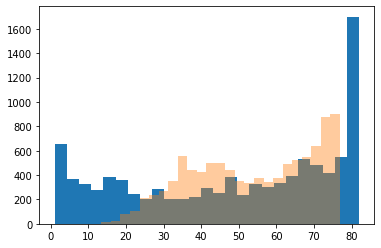

In [140]:
#alpha 66 beta 16
#plt.scatter(predictions_df['actual'], predictions_df['predicted'])
plt.hist(df['gp'], bins=25)
plt.hist(df['point_prediction'], bins=25, alpha=.4)
#plt.title("Alpha 64 beta 18")
plt.show()

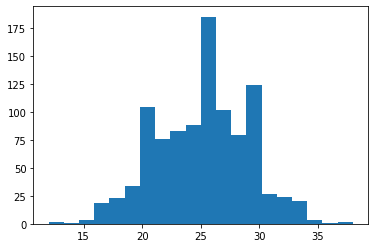

In [141]:
crosby = df[df.api_id == 8471675].head(20)

plt.hist(crosby[crosby.season == 20122013]['prediction_samples'], bins=20)
plt.show()

In [ ]:

for player in players:
    if player == 8471675:
        print("crosby")
    player_df = train_gp_df[train_gp_df.api_id == player]
    if player_df.shape[0] == 1 and player not in test_players:
        continue
    prior_alpha = 66
    prior_beta = 16
    posterior_alpha = 0
    posterior_beta = 0
    possible_games = 0
    previous_season = 0
    for i, season in enumerate(seasons):
        if season < player_df.season.min():
            continue
        if season > player_df.season.max():
            break
        if season not in player_df.season.values:
            continue
            
        season_df = player_df[player_df.season == season]
        
        if posterior_alpha == 0:
            
           
            posterior_alpha = prior_alpha + season_df['gp'].values[0]
            posterior_beta = prior_beta + season_df['possible_gp'].values[0] - season_df['gp'].values[0]
            previous_season = season_df['season'].values[0]
            
            if posterior_beta <= 0:
                posterior_beta = 1
        else:
            missed_gp_add = 0
            if season_df.season.values[0] - previous_season != 10001:
                for i in range(((season_df.season.values[0] - previous_season)//10001)-1) :
                    if previous_season + ((i+1) * 10001) == 20122013:
                        missed_gp_add += 48
                    else:
                        missed_gp_add += 82
            #print(player, season, posterior_alpha, posterior_beta, season_df['possible_gp'].values[0], missed_gp_add)
            if season == 20122013:
                predicted_games = betabinom.rvs(48, posterior_alpha, posterior_beta, size=100).mean()
            else:
                predicted_games = betabinom.rvs(int(season_df['possible_gp'].values[0]), posterior_alpha, posterior_beta, size=100).mean()
            predictions.append([player, season, predicted_games, season_df['gp'].values[0], posterior_alpha, posterior_beta])
            posterior_alpha += season_df['gp'].values[0]
            #print(posterior_beta, season_df['possible_gp'].values[0], missed_gp_add, season_df['gp'].values[0])
            posterior_beta = posterior_beta + season_df['possible_gp'].values[0] + missed_gp_add - season_df['gp'].values[0]
            if posterior_beta <= 0:
                posterior_beta = 1
            previous_season = season_df['season'].values[0]

